In [6]:
import os

In [1]:
import numpy as np
from torch import nn
from torch.nn import functional as F
import torch
from torch import optim
from torchvision import datasets,transforms
from torchinfo import summary
import albumentations as A
from albumentations.pytorch import ToTensorV2

from transformations import (train_transforms,test_transforms,no_transforms)


torch.cuda.amp.autocast(enabled=True, dtype=torch.float16, cache_enabled=False)

from trainer import Trainer
from tester import Tester
from utlis import visualize_data,show_misclassified_images,device,is_cuda
from viz import plot_class_distribution, plot_confusion_matrix, plot_curves
from dataloader import CIFAR10Dataset,CIFAR10DataLoader
from models import ConvLayer,TransBlock,DepthwiseConvLayer


# Augmentation
atrain_dataset = CIFAR10Dataset(root='../data/',train=True,Atransforms=train_transforms,download=False)
atest_dataset  = CIFAR10Dataset(root='../data/',train=False,Atransforms=test_transforms,download=False)
acifar = CIFAR10DataLoader(batch_size=512,is_cuda_available=True)
atrain_loader, atest_loader = acifar.get_loader(atrain_dataset,atest_dataset)


# No Augmentation
train_dataset = CIFAR10Dataset(root='../data/',train=True,Atransforms=no_transforms,download=False)
test_dataset  = CIFAR10Dataset(root='../data/',train=False,Atransforms=no_transforms,download=False)
cifar = CIFAR10DataLoader(batch_size=512,is_cuda_available=True)
train_loader, test_loader = cifar.get_loader(train_dataset,test_dataset)

C:\Users\muthu\Documents\TSAI\session 9\utlis.py:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


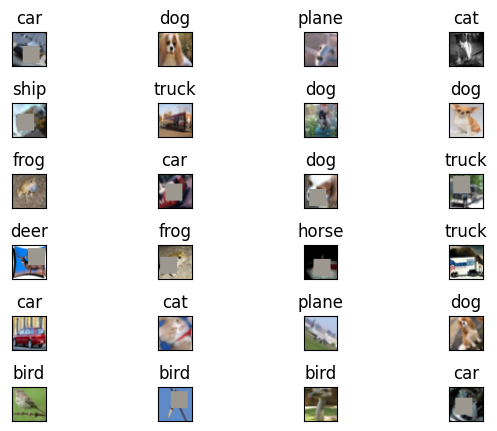

In [2]:
visualize_data(atrain_loader,classes=acifar.classes,num_figures=24)

C:\Users\muthu\Documents\TSAI\session 9\utlis.py:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


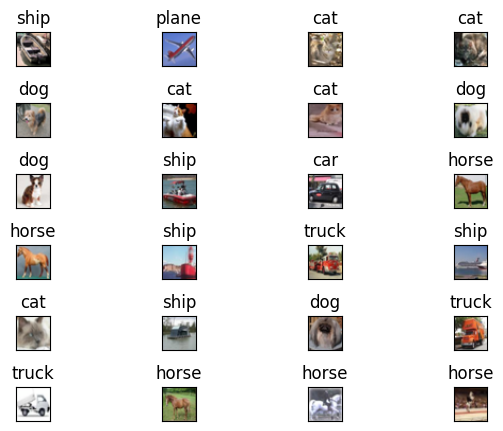

In [3]:
visualize_data(atest_loader,classes=cifar.classes,num_figures=24)

**large model with augmentation**

In [4]:
dp_rate = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = ConvLayer(inc=3,outc=8,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        
        self.conv2 = ConvLayer(         inc=8,outc=16,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        self.dep2  = DepthwiseConvLayer(inc=8,outc=16,p=1,s=1,dp_rate=dp_rate)
        self.dil2  = ConvLayer(         inc=8,outc=16,k=3,p=2,s=1,d=2,dp_rate=dp_rate)

        self.conv3 = ConvLayer(         inc=16,outc=32,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        self.dep3  = DepthwiseConvLayer(inc=16,outc=32,p=1,s=1,dp_rate=dp_rate)
        self.dil3  = ConvLayer(         inc=16,outc=32,k=3,p=2,s=1,d=2,dp_rate=dp_rate)

        self.trans4 = TransBlock(56,16,p=0,s=2)


        self.conv5 = ConvLayer(16,32,k=3,p=1,s=1,d=1,dp_rate=dp_rate)

        self.conv6 = ConvLayer(         inc=32,outc=48,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        self.dep6  = DepthwiseConvLayer(inc=32,outc=48,p=1,s=1,dp_rate=dp_rate)
        self.dil6  = ConvLayer(         inc=32,outc=48,k=3,p=2,s=1,d=2,dp_rate=dp_rate)

        self.conv7 = ConvLayer(         inc=48,outc=56,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        self.dep7  = DepthwiseConvLayer(inc=48,outc=56,p=1,s=1,dp_rate=dp_rate)
        self.dil7  = ConvLayer(         inc=48,outc=56,k=3,p=2,s=1,d=2,dp_rate=dp_rate)
      
        self.trans8 = TransBlock(136,24,p=0,s=2)

        
        self.conv9 = ConvLayer(24,40,k=3,p=1,s=1,d=1,dp_rate=dp_rate)

        self.conv10 = ConvLayer(         inc=40,outc=48,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        self.dep10  = DepthwiseConvLayer(inc=40,outc=48,p=1,s=1,dp_rate=dp_rate)
        self.dil10  = ConvLayer(         inc=40,outc=48,k=3,p=4,s=1,d=4,dp_rate=dp_rate)


        self.conv_ = ConvLayer(         inc=48,outc=48,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        self.dep_  = DepthwiseConvLayer(inc=48,outc=48,p=1,s=1,dp_rate=dp_rate)
        self.dil_  = ConvLayer(         inc=48,outc=48,k=3,p=4,s=1,d=4,dp_rate=dp_rate)

        self.trans11 = TransBlock(88,40,p=0,s=1)
        self.trans12 = TransBlock(40,20,p=0,s=1)
        self.out = TransBlock(inc=20,outc=10,p=0,s=1)
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        
    
    def forward(self,x):        
        x0 = self.conv1(x)
        x1 = self.dep2(x0) + self.conv2(x0) + self.dil2(x0) 
        x2 = self.dep3(x1) + self.conv3(x1) + self.dil3(x1) 
        x3 = torch.concat((x0,x1,x2),dim=1)
        x4 = self.trans4(x3)

        x5 = self.conv5(x4)
        x6 = self.conv6(x5) + self.dep6(x5) + self.dil6(x5)
        x7 = self.conv7(x6)+ self.dep7(x6)+ self.dil7(x6)
        x8 = torch.concat((x5,x6,x7),dim=1)
        x9  = self.trans8(x8)

        x10 = self.conv9(x9)
        x11 = self.conv10(x10) + self.dep10(x10) + self.dil10(x10)
        x11 = self.conv_(x11) + self.dep_(x11) + self.dil_(x11)
        x12 = torch.concat((x10,x11),dim=1)
        x  = self.trans11(x12)
        x  = self.trans12(x)
        
        x = self.out(x)
        x = self.gap(x)
        return  F.log_softmax(x.view(-1,10), dim=1)

model = Net().to(device)
summary(model,input_size=(1,3,32,32),device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─ConvLayer: 1-1                         [1, 8, 32, 32]            --
│    └─Sequential: 2-1                   [1, 8, 32, 32]            --
│    │    └─Conv2d: 3-1                  [1, 8, 32, 32]            216
│    │    └─BatchNorm2d: 3-2             [1, 8, 32, 32]            16
│    │    └─ReLU: 3-3                    [1, 8, 32, 32]            --
│    │    └─Dropout2d: 3-4               [1, 8, 32, 32]            --
├─DepthwiseConvLayer: 1-2                [1, 16, 32, 32]           --
│    └─Sequential: 2-2                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-5                  [1, 8, 32, 32]            72
│    │    └─Conv2d: 3-6                  [1, 16, 32, 32]           128
│    │    └─ReLU: 3-7                    [1, 16, 32, 32]           --
│    │    └─BatchNorm2d: 3-8             [1, 16, 32, 32]           32
│    │    └─D

In [7]:
prev_test_loss = float('inf')

if os.path.isfile(r"C:\Users\muthu\Documents\TSAI\session 9\bmodels\model2.pth"): model.load_state_dict(torch.load(r"C:\Users\muthu\Documents\TSAI\session 9\bmodels\model2.pth"))


optimizer = optim.SGD(params=model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=3)
criterion = nn.NLLLoss()
trainer = Trainer(model=model, train_loader=atrain_loader, optimizer=optimizer, criterion=criterion, device=device)
tester = Tester(model=model, test_loader=atest_loader,criterion=criterion, device=device)

for epoch in range(1, 101):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(obj=model.state_dict(),f='./bmodels/model2.pth')
    scheduler.step(test_loss)

EPOCH = 1 | LR = 0.1 | Loss = 1.78 | Batch = 97 | Accuracy = 27.76: 100%|███| 98/98 [00:41<00:00,  2.38it/s]


Test set: Average loss: 0.0032, Accuracy: 4023/10000 (40.23%)


EPOCH = 2 | LR = 0.1 | Loss = 1.63 | Batch = 97 | Accuracy = 36.58: 100%|███| 98/98 [00:41<00:00,  2.39it/s]


Test set: Average loss: 0.0028, Accuracy: 4716/10000 (47.16%)


EPOCH = 3 | LR = 0.1 | Loss = 1.62 | Batch = 97 | Accuracy = 40.79: 100%|███| 98/98 [00:40<00:00,  2.43it/s]


Test set: Average loss: 0.0027, Accuracy: 4978/10000 (49.78%)


EPOCH = 4 | LR = 0.1 | Loss = 1.47 | Batch = 97 | Accuracy = 44.31: 100%|███| 98/98 [00:40<00:00,  2.41it/s]


Test set: Average loss: 0.0026, Accuracy: 5292/10000 (52.92%)


EPOCH = 5 | LR = 0.1 | Loss = 1.45 | Batch = 97 | Accuracy = 46.38: 100%|███| 98/98 [00:40<00:00,  2.44it/s]


Test set: Average loss: 0.0024, Accuracy: 5653/10000 (56.53%)


EPOCH = 6 | LR = 0.1 | Loss = 1.43 | Batch = 97 | Accuracy = 47.90: 100%|███| 98/98 [00:40<00:00,  2.44it/s]


Test set: Average loss: 0.0022, Accuracy: 5960/10000 (59.60%)


EPOCH = 7 | LR = 0.1 | Loss = 1.37 | Batch = 97 | Accuracy = 50.11: 100%|███| 98/98 [00:40<00:00,  2.45it/s]


Test set: Average loss: 0.0022, Accuracy: 5948/10000 (59.48%)


EPOCH = 8 | LR = 0.1 | Loss = 1.34 | Batch = 97 | Accuracy = 51.84: 100%|███| 98/98 [00:40<00:00,  2.41it/s]


Test set: Average loss: 0.0020, Accuracy: 6272/10000 (62.72%)


EPOCH = 9 | LR = 0.1 | Loss = 1.21 | Batch = 97 | Accuracy = 53.34: 100%|███| 98/98 [00:42<00:00,  2.30it/s]


Test set: Average loss: 0.0019, Accuracy: 6529/10000 (65.29%)


EPOCH = 10 | LR = 0.1 | Loss = 1.25 | Batch = 97 | Accuracy = 54.29: 100%|██| 98/98 [00:40<00:00,  2.43it/s]


Test set: Average loss: 0.0019, Accuracy: 6637/10000 (66.37%)


EPOCH = 11 | LR = 0.1 | Loss = 1.29 | Batch = 97 | Accuracy = 55.51: 100%|██| 98/98 [00:40<00:00,  2.44it/s]


Test set: Average loss: 0.0018, Accuracy: 6719/10000 (67.19%)


EPOCH = 12 | LR = 0.1 | Loss = 1.12 | Batch = 97 | Accuracy = 56.63: 100%|██| 98/98 [00:40<00:00,  2.43it/s]


Test set: Average loss: 0.0018, Accuracy: 6859/10000 (68.59%)


EPOCH = 13 | LR = 0.1 | Loss = 1.27 | Batch = 97 | Accuracy = 57.48: 100%|██| 98/98 [00:40<00:00,  2.41it/s]


Test set: Average loss: 0.0018, Accuracy: 6812/10000 (68.12%)


EPOCH = 14 | LR = 0.1 | Loss = 1.18 | Batch = 97 | Accuracy = 58.42: 100%|██| 98/98 [00:40<00:00,  2.43it/s]


Test set: Average loss: 0.0016, Accuracy: 7205/10000 (72.05%)


EPOCH = 15 | LR = 0.1 | Loss = 1.12 | Batch = 97 | Accuracy = 59.23: 100%|██| 98/98 [00:40<00:00,  2.43it/s]


Test set: Average loss: 0.0016, Accuracy: 7288/10000 (72.88%)


EPOCH = 16 | LR = 0.1 | Loss = 1.09 | Batch = 97 | Accuracy = 59.84: 100%|██| 98/98 [00:40<00:00,  2.42it/s]


Test set: Average loss: 0.0017, Accuracy: 7095/10000 (70.95%)


EPOCH = 17 | LR = 0.1 | Loss = 1.10 | Batch = 97 | Accuracy = 60.28: 100%|██| 98/98 [00:40<00:00,  2.42it/s]


Test set: Average loss: 0.0015, Accuracy: 7364/10000 (73.64%)


EPOCH = 18 | LR = 0.1 | Loss = 1.11 | Batch = 97 | Accuracy = 61.05: 100%|██| 98/98 [00:40<00:00,  2.43it/s]


Test set: Average loss: 0.0015, Accuracy: 7361/10000 (73.61%)


EPOCH = 19 | LR = 0.1 | Loss = 1.00 | Batch = 97 | Accuracy = 61.04: 100%|██| 98/98 [00:40<00:00,  2.43it/s]


Test set: Average loss: 0.0015, Accuracy: 7339/10000 (73.39%)


EPOCH = 20 | LR = 0.1 | Loss = 1.02 | Batch = 97 | Accuracy = 61.89: 100%|██| 98/98 [00:40<00:00,  2.43it/s]


Test set: Average loss: 0.0015, Accuracy: 7335/10000 (73.35%)


EPOCH = 21 | LR = 0.1 | Loss = 1.00 | Batch = 97 | Accuracy = 62.66: 100%|██| 98/98 [00:40<00:00,  2.41it/s]


Test set: Average loss: 0.0014, Accuracy: 7629/10000 (76.29%)


EPOCH = 22 | LR = 0.1 | Loss = 1.10 | Batch = 97 | Accuracy = 62.77: 100%|██| 98/98 [00:40<00:00,  2.42it/s]


Test set: Average loss: 0.0015, Accuracy: 7426/10000 (74.26%)


EPOCH = 23 | LR = 0.1 | Loss = 1.09 | Batch = 97 | Accuracy = 63.00: 100%|██| 98/98 [00:40<00:00,  2.43it/s]


Test set: Average loss: 0.0014, Accuracy: 7504/10000 (75.04%)


EPOCH = 24 | LR = 0.1 | Loss = 1.05 | Batch = 97 | Accuracy = 63.30: 100%|██| 98/98 [00:40<00:00,  2.42it/s]


Test set: Average loss: 0.0014, Accuracy: 7606/10000 (76.06%)


EPOCH = 25 | LR = 0.1 | Loss = 1.04 | Batch = 97 | Accuracy = 63.89: 100%|██| 98/98 [00:40<00:00,  2.42it/s]


Test set: Average loss: 0.0014, Accuracy: 7540/10000 (75.40%)


EPOCH = 26 | LR = 0.1 | Loss = 1.00 | Batch = 97 | Accuracy = 64.16: 100%|██| 98/98 [00:40<00:00,  2.40it/s]


Test set: Average loss: 0.0014, Accuracy: 7552/10000 (75.52%)


EPOCH = 27 | LR = 0.1 | Loss = 1.05 | Batch = 97 | Accuracy = 64.37: 100%|██| 98/98 [00:40<00:00,  2.41it/s]


Test set: Average loss: 0.0013, Accuracy: 7744/10000 (77.44%)


EPOCH = 28 | LR = 0.1 | Loss = 1.00 | Batch = 97 | Accuracy = 64.89: 100%|██| 98/98 [00:40<00:00,  2.42it/s]


Test set: Average loss: 0.0014, Accuracy: 7657/10000 (76.57%)


EPOCH = 29 | LR = 0.1 | Loss = 0.98 | Batch = 97 | Accuracy = 64.78: 100%|██| 98/98 [00:40<00:00,  2.43it/s]


Test set: Average loss: 0.0013, Accuracy: 7676/10000 (76.76%)


EPOCH = 30 | LR = 0.1 | Loss = 1.03 | Batch = 97 | Accuracy = 65.22: 100%|██| 98/98 [00:40<00:00,  2.42it/s]


Test set: Average loss: 0.0013, Accuracy: 7726/10000 (77.26%)


EPOCH = 31 | LR = 0.1 | Loss = 0.95 | Batch = 97 | Accuracy = 65.68: 100%|██| 98/98 [00:40<00:00,  2.42it/s]


Test set: Average loss: 0.0013, Accuracy: 7829/10000 (78.29%)


EPOCH = 32 | LR = 0.1 | Loss = 0.90 | Batch = 97 | Accuracy = 65.90: 100%|██| 98/98 [00:40<00:00,  2.44it/s]


Test set: Average loss: 0.0013, Accuracy: 7870/10000 (78.70%)


EPOCH = 33 | LR = 0.1 | Loss = 1.08 | Batch = 97 | Accuracy = 65.91: 100%|██| 98/98 [00:40<00:00,  2.41it/s]


Test set: Average loss: 0.0013, Accuracy: 7863/10000 (78.63%)


EPOCH = 34 | LR = 0.1 | Loss = 0.97 | Batch = 97 | Accuracy = 66.06: 100%|██| 98/98 [00:40<00:00,  2.43it/s]


Test set: Average loss: 0.0014, Accuracy: 7698/10000 (76.98%)


EPOCH = 35 | LR = 0.1 | Loss = 0.95 | Batch = 97 | Accuracy = 66.52: 100%|██| 98/98 [00:40<00:00,  2.45it/s]


Test set: Average loss: 0.0012, Accuracy: 7885/10000 (78.85%)


EPOCH = 36 | LR = 0.1 | Loss = 0.98 | Batch = 97 | Accuracy = 66.75: 100%|██| 98/98 [00:40<00:00,  2.42it/s]


Test set: Average loss: 0.0012, Accuracy: 7947/10000 (79.47%)


EPOCH = 37 | LR = 0.1 | Loss = 0.98 | Batch = 97 | Accuracy = 66.51: 100%|██| 98/98 [00:40<00:00,  2.43it/s]


Test set: Average loss: 0.0013, Accuracy: 7852/10000 (78.52%)


EPOCH = 38 | LR = 0.1 | Loss = 0.94 | Batch = 97 | Accuracy = 67.03: 100%|██| 98/98 [00:40<00:00,  2.43it/s]


Test set: Average loss: 0.0012, Accuracy: 7926/10000 (79.26%)


EPOCH = 39 | LR = 0.1 | Loss = 0.95 | Batch = 97 | Accuracy = 67.24: 100%|██| 98/98 [00:40<00:00,  2.43it/s]


Test set: Average loss: 0.0012, Accuracy: 7970/10000 (79.70%)


EPOCH = 40 | LR = 0.1 | Loss = 0.96 | Batch = 97 | Accuracy = 67.44: 100%|██| 98/98 [00:40<00:00,  2.42it/s]


Test set: Average loss: 0.0012, Accuracy: 8026/10000 (80.26%)


EPOCH = 41 | LR = 0.1 | Loss = 0.89 | Batch = 97 | Accuracy = 67.60: 100%|██| 98/98 [00:40<00:00,  2.41it/s]


Test set: Average loss: 0.0012, Accuracy: 8016/10000 (80.16%)


EPOCH = 42 | LR = 0.1 | Loss = 0.89 | Batch = 97 | Accuracy = 67.69: 100%|██| 98/98 [00:40<00:00,  2.43it/s]


Test set: Average loss: 0.0012, Accuracy: 7992/10000 (79.92%)


EPOCH = 43 | LR = 0.1 | Loss = 1.03 | Batch = 97 | Accuracy = 67.74: 100%|██| 98/98 [00:40<00:00,  2.42it/s]


Test set: Average loss: 0.0012, Accuracy: 8022/10000 (80.22%)


EPOCH = 44 | LR = 0.1 | Loss = 0.85 | Batch = 97 | Accuracy = 67.84: 100%|██| 98/98 [00:40<00:00,  2.42it/s]


Test set: Average loss: 0.0012, Accuracy: 8004/10000 (80.04%)


EPOCH = 45 | LR = 0.1 | Loss = 0.87 | Batch = 97 | Accuracy = 67.88: 100%|██| 98/98 [00:40<00:00,  2.43it/s]


Test set: Average loss: 0.0011, Accuracy: 8082/10000 (80.82%)


EPOCH = 46 | LR = 0.1 | Loss = 0.85 | Batch = 97 | Accuracy = 68.01: 100%|██| 98/98 [00:40<00:00,  2.42it/s]


Test set: Average loss: 0.0012, Accuracy: 7986/10000 (79.86%)


EPOCH = 47 | LR = 0.1 | Loss = 0.82 | Batch = 97 | Accuracy = 68.31: 100%|██| 98/98 [00:40<00:00,  2.43it/s]


Test set: Average loss: 0.0012, Accuracy: 8021/10000 (80.21%)


EPOCH = 48 | LR = 0.1 | Loss = 0.94 | Batch = 97 | Accuracy = 68.36: 100%|██| 98/98 [00:40<00:00,  2.43it/s]


Test set: Average loss: 0.0012, Accuracy: 7952/10000 (79.52%)


EPOCH = 49 | LR = 0.1 | Loss = 0.91 | Batch = 97 | Accuracy = 68.57: 100%|██| 98/98 [00:40<00:00,  2.42it/s]


Test set: Average loss: 0.0011, Accuracy: 8031/10000 (80.31%)


EPOCH = 50 | LR = 0.010000000000000002 | Loss = 0.92 | Batch = 97 | Accuracy = 69.70: 100%|█| 98/98 [00:40<0


Test set: Average loss: 0.0011, Accuracy: 8192/10000 (81.92%)


EPOCH = 51 | LR = 0.010000000000000002 | Loss = 0.77 | Batch = 97 | Accuracy = 70.20: 100%|█| 98/98 [00:40<0


Test set: Average loss: 0.0011, Accuracy: 8186/10000 (81.86%)


EPOCH = 52 | LR = 0.010000000000000002 | Loss = 0.79 | Batch = 97 | Accuracy = 70.53: 100%|█| 98/98 [00:40<0


Test set: Average loss: 0.0011, Accuracy: 8168/10000 (81.68%)


EPOCH = 53 | LR = 0.010000000000000002 | Loss = 0.82 | Batch = 97 | Accuracy = 70.83: 100%|█| 98/98 [00:40<0


Test set: Average loss: 0.0010, Accuracy: 8217/10000 (82.17%)


EPOCH = 54 | LR = 0.010000000000000002 | Loss = 0.89 | Batch = 97 | Accuracy = 70.78: 100%|█| 98/98 [00:40<0


Test set: Average loss: 0.0011, Accuracy: 8188/10000 (81.88%)


EPOCH = 55 | LR = 0.010000000000000002 | Loss = 0.89 | Batch = 97 | Accuracy = 70.87: 100%|█| 98/98 [00:40<0


Test set: Average loss: 0.0011, Accuracy: 8201/10000 (82.01%)


EPOCH = 56 | LR = 0.010000000000000002 | Loss = 0.83 | Batch = 97 | Accuracy = 70.85: 100%|█| 98/98 [00:40<0


Test set: Average loss: 0.0010, Accuracy: 8195/10000 (81.95%)


EPOCH = 57 | LR = 0.010000000000000002 | Loss = 0.83 | Batch = 97 | Accuracy = 70.52: 100%|█| 98/98 [00:40<0


Test set: Average loss: 0.0011, Accuracy: 8231/10000 (82.31%)


EPOCH = 58 | LR = 0.0010000000000000002 | Loss = 0.72 | Batch = 97 | Accuracy = 71.42: 100%|█| 98/98 [00:40<


Test set: Average loss: 0.0010, Accuracy: 8233/10000 (82.33%)


EPOCH = 59 | LR = 0.0010000000000000002 | Loss = 0.96 | Batch = 97 | Accuracy = 71.04: 100%|█| 98/98 [00:40<


Test set: Average loss: 0.0010, Accuracy: 8239/10000 (82.39%)


EPOCH = 60 | LR = 0.0010000000000000002 | Loss = 0.85 | Batch = 97 | Accuracy = 71.04: 100%|█| 98/98 [00:40<


Test set: Average loss: 0.0010, Accuracy: 8241/10000 (82.41%)


EPOCH = 61 | LR = 0.0010000000000000002 | Loss = 0.96 | Batch = 97 | Accuracy = 70.80: 100%|█| 98/98 [00:40<


Test set: Average loss: 0.0010, Accuracy: 8231/10000 (82.31%)


EPOCH = 62 | LR = 0.0010000000000000002 | Loss = 0.82 | Batch = 97 | Accuracy = 71.14: 100%|█| 98/98 [00:40<


Test set: Average loss: 0.0010, Accuracy: 8237/10000 (82.37%)


EPOCH = 63 | LR = 0.0010000000000000002 | Loss = 0.85 | Batch = 97 | Accuracy = 70.95: 100%|█| 98/98 [00:40<


Test set: Average loss: 0.0010, Accuracy: 8241/10000 (82.41%)


EPOCH = 64 | LR = 0.00010000000000000003 | Loss = 0.80 | Batch = 97 | Accuracy = 71.21: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8237/10000 (82.37%)


EPOCH = 65 | LR = 0.00010000000000000003 | Loss = 0.85 | Batch = 97 | Accuracy = 71.06: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8243/10000 (82.43%)


EPOCH = 66 | LR = 0.00010000000000000003 | Loss = 0.72 | Batch = 97 | Accuracy = 71.07: 100%|█| 98/98 [00:41


Test set: Average loss: 0.0010, Accuracy: 8238/10000 (82.38%)


EPOCH = 67 | LR = 0.00010000000000000003 | Loss = 0.86 | Batch = 97 | Accuracy = 70.93: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8235/10000 (82.35%)


EPOCH = 68 | LR = 1.0000000000000004e-05 | Loss = 0.89 | Batch = 97 | Accuracy = 71.27: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8230/10000 (82.30%)


EPOCH = 69 | LR = 1.0000000000000004e-05 | Loss = 0.91 | Batch = 97 | Accuracy = 71.25: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8236/10000 (82.36%)


EPOCH = 70 | LR = 1.0000000000000004e-05 | Loss = 0.90 | Batch = 97 | Accuracy = 71.09: 100%|█| 98/98 [00:41


Test set: Average loss: 0.0010, Accuracy: 8231/10000 (82.31%)


EPOCH = 71 | LR = 1.0000000000000004e-05 | Loss = 0.75 | Batch = 97 | Accuracy = 71.58: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8238/10000 (82.38%)


EPOCH = 72 | LR = 1.0000000000000004e-06 | Loss = 0.88 | Batch = 97 | Accuracy = 71.10: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8243/10000 (82.43%)


EPOCH = 73 | LR = 1.0000000000000004e-06 | Loss = 0.76 | Batch = 97 | Accuracy = 71.21: 100%|█| 98/98 [00:41


Test set: Average loss: 0.0010, Accuracy: 8241/10000 (82.41%)


EPOCH = 74 | LR = 1.0000000000000004e-06 | Loss = 0.91 | Batch = 97 | Accuracy = 71.42: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8242/10000 (82.42%)


EPOCH = 75 | LR = 1.0000000000000004e-06 | Loss = 0.81 | Batch = 97 | Accuracy = 71.26: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8225/10000 (82.25%)


EPOCH = 76 | LR = 1.0000000000000005e-07 | Loss = 0.83 | Batch = 97 | Accuracy = 71.07: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8243/10000 (82.43%)


EPOCH = 77 | LR = 1.0000000000000005e-07 | Loss = 0.86 | Batch = 97 | Accuracy = 70.96: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8228/10000 (82.28%)


EPOCH = 78 | LR = 1.0000000000000005e-07 | Loss = 0.74 | Batch = 97 | Accuracy = 71.47: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8243/10000 (82.43%)


EPOCH = 79 | LR = 1.0000000000000005e-07 | Loss = 0.76 | Batch = 97 | Accuracy = 71.32: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8238/10000 (82.38%)


EPOCH = 80 | LR = 1.0000000000000005e-07 | Loss = 0.86 | Batch = 97 | Accuracy = 71.25: 100%|█| 98/98 [00:41


Test set: Average loss: 0.0010, Accuracy: 8243/10000 (82.43%)


EPOCH = 81 | LR = 1.0000000000000005e-07 | Loss = 0.88 | Batch = 97 | Accuracy = 71.27: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8245/10000 (82.45%)


EPOCH = 82 | LR = 1.0000000000000005e-07 | Loss = 0.92 | Batch = 97 | Accuracy = 71.28: 100%|█| 98/98 [00:43


Test set: Average loss: 0.0010, Accuracy: 8244/10000 (82.44%)


EPOCH = 83 | LR = 1.0000000000000005e-08 | Loss = 0.80 | Batch = 97 | Accuracy = 70.98: 100%|█| 98/98 [00:41


Test set: Average loss: 0.0010, Accuracy: 8245/10000 (82.45%)


EPOCH = 84 | LR = 1.0000000000000005e-08 | Loss = 0.79 | Batch = 97 | Accuracy = 71.02: 100%|█| 98/98 [00:41


Test set: Average loss: 0.0010, Accuracy: 8243/10000 (82.43%)


EPOCH = 85 | LR = 1.0000000000000005e-08 | Loss = 0.99 | Batch = 97 | Accuracy = 71.21: 100%|█| 98/98 [00:41


Test set: Average loss: 0.0010, Accuracy: 8249/10000 (82.49%)


EPOCH = 86 | LR = 1.0000000000000005e-08 | Loss = 0.75 | Batch = 97 | Accuracy = 70.99: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8242/10000 (82.42%)


EPOCH = 87 | LR = 1.0000000000000005e-08 | Loss = 0.71 | Batch = 97 | Accuracy = 71.13: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8240/10000 (82.40%)


EPOCH = 88 | LR = 1.0000000000000005e-08 | Loss = 0.80 | Batch = 97 | Accuracy = 71.29: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8235/10000 (82.35%)


EPOCH = 89 | LR = 1.0000000000000005e-08 | Loss = 0.79 | Batch = 97 | Accuracy = 71.19: 100%|█| 98/98 [00:41


Test set: Average loss: 0.0010, Accuracy: 8234/10000 (82.34%)


EPOCH = 90 | LR = 1.0000000000000005e-08 | Loss = 0.78 | Batch = 97 | Accuracy = 71.10: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8241/10000 (82.41%)


EPOCH = 91 | LR = 1.0000000000000005e-08 | Loss = 0.89 | Batch = 97 | Accuracy = 71.28: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8241/10000 (82.41%)


EPOCH = 92 | LR = 1.0000000000000005e-08 | Loss = 0.92 | Batch = 97 | Accuracy = 71.11: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8240/10000 (82.40%)


EPOCH = 93 | LR = 1.0000000000000005e-08 | Loss = 0.81 | Batch = 97 | Accuracy = 71.05: 100%|█| 98/98 [00:41


Test set: Average loss: 0.0010, Accuracy: 8235/10000 (82.35%)


EPOCH = 94 | LR = 1.0000000000000005e-08 | Loss = 0.81 | Batch = 97 | Accuracy = 71.29: 100%|█| 98/98 [00:41


Test set: Average loss: 0.0010, Accuracy: 8241/10000 (82.41%)


EPOCH = 95 | LR = 1.0000000000000005e-08 | Loss = 0.80 | Batch = 97 | Accuracy = 70.91: 100%|█| 98/98 [00:41


Test set: Average loss: 0.0010, Accuracy: 8239/10000 (82.39%)


EPOCH = 96 | LR = 1.0000000000000005e-08 | Loss = 0.81 | Batch = 97 | Accuracy = 71.00: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8241/10000 (82.41%)


EPOCH = 97 | LR = 1.0000000000000005e-08 | Loss = 0.90 | Batch = 97 | Accuracy = 70.95: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8241/10000 (82.41%)


EPOCH = 98 | LR = 1.0000000000000005e-08 | Loss = 0.72 | Batch = 97 | Accuracy = 71.15: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8239/10000 (82.39%)


EPOCH = 99 | LR = 1.0000000000000005e-08 | Loss = 0.86 | Batch = 97 | Accuracy = 71.02: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0010, Accuracy: 8248/10000 (82.48%)


EPOCH = 100 | LR = 1.0000000000000005e-08 | Loss = 0.80 | Batch = 97 | Accuracy = 71.15: 100%|█| 98/98 [00:4


Test set: Average loss: 0.0010, Accuracy: 8216/10000 (82.16%)


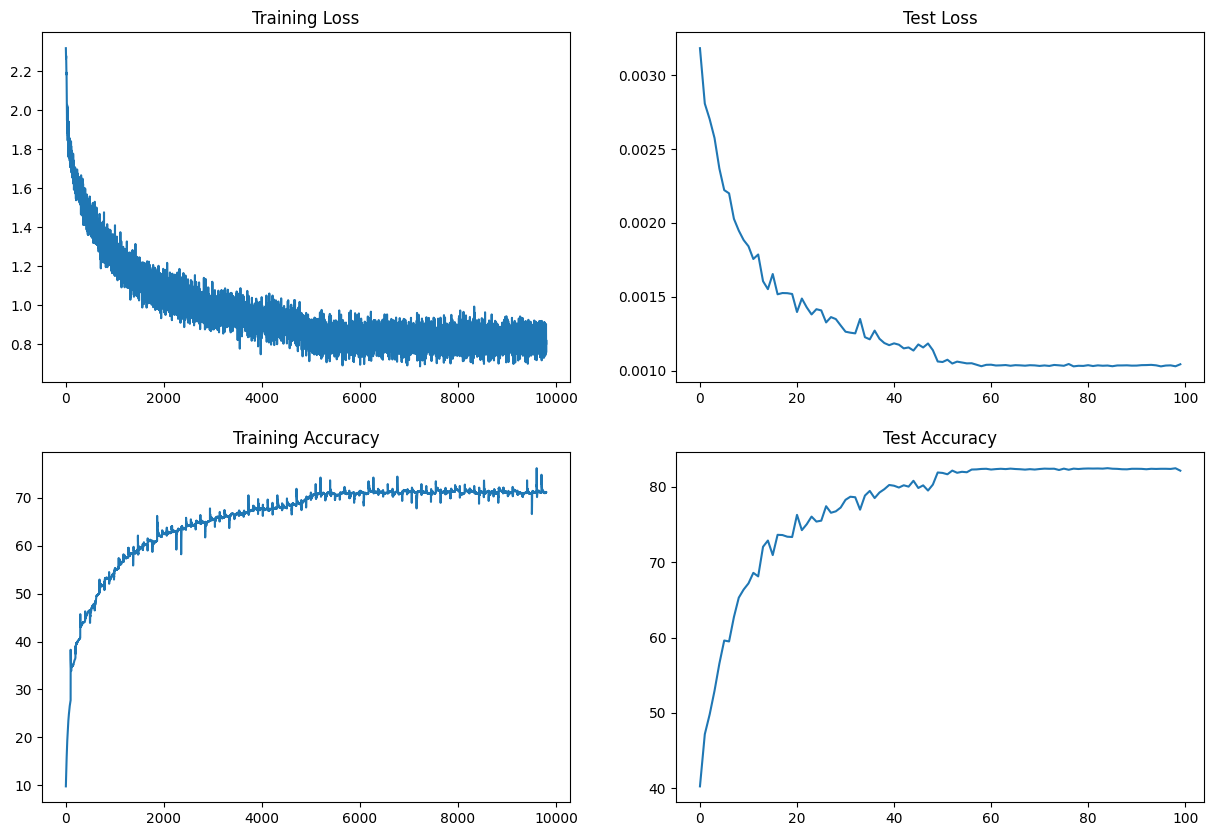

In [8]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)

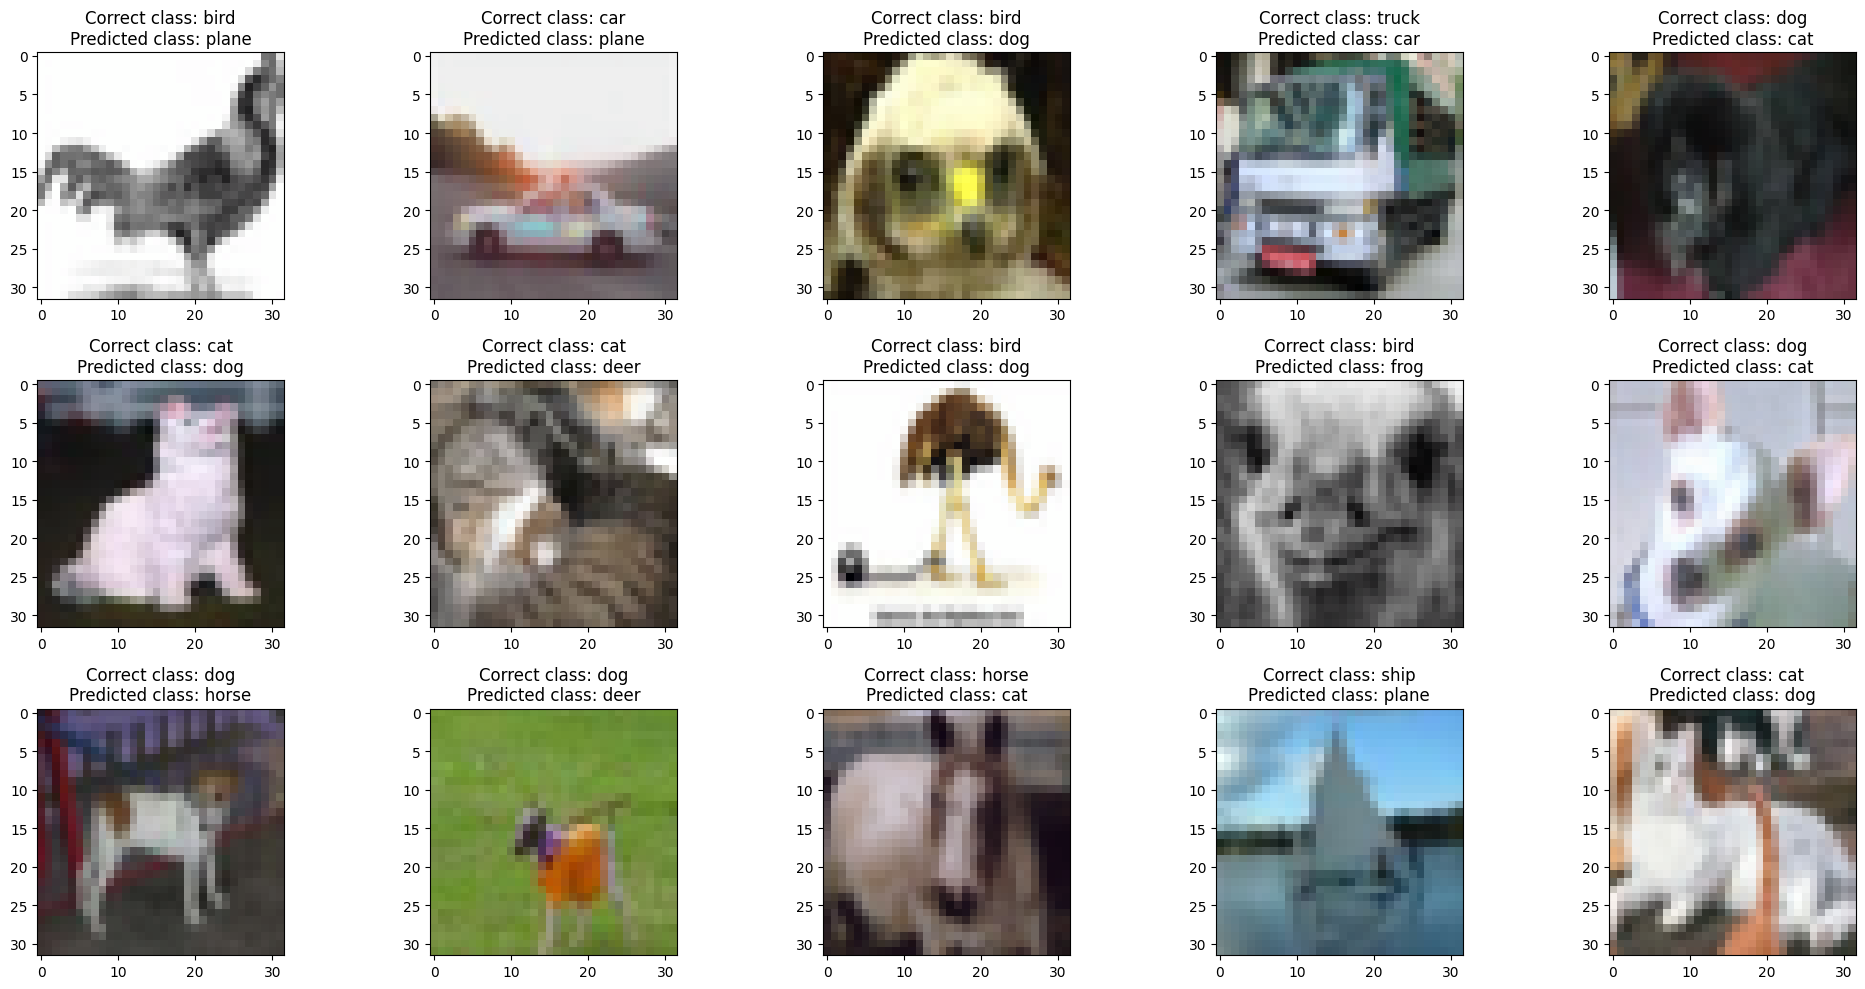

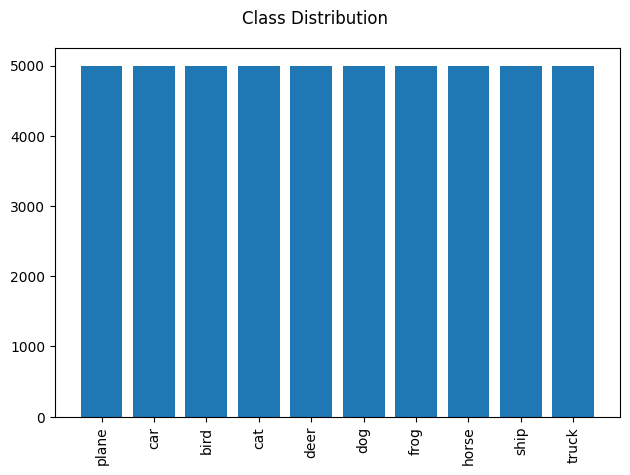

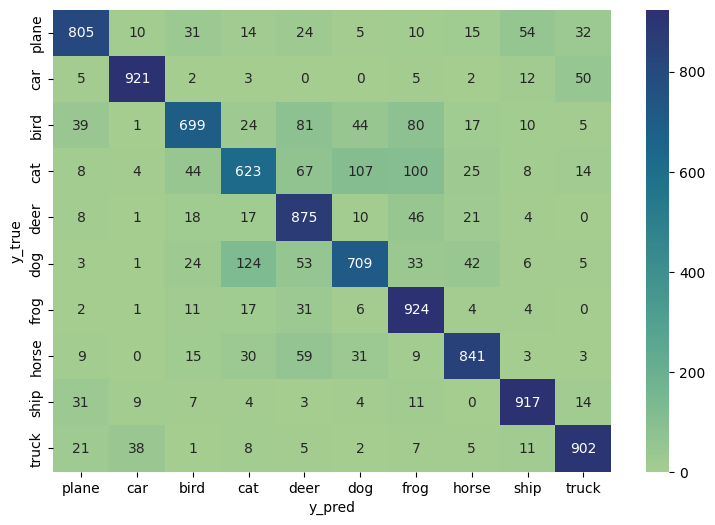

In [9]:
images, predictions, labels =  tester.get_misclassified_images()
show_misclassified_images(images[:15],predictions[:15],labels[:15],cifar.classes)
plot_class_distribution(atrain_loader,cifar.classes)
plot_confusion_matrix(model,atest_loader,device,cifar.classes)

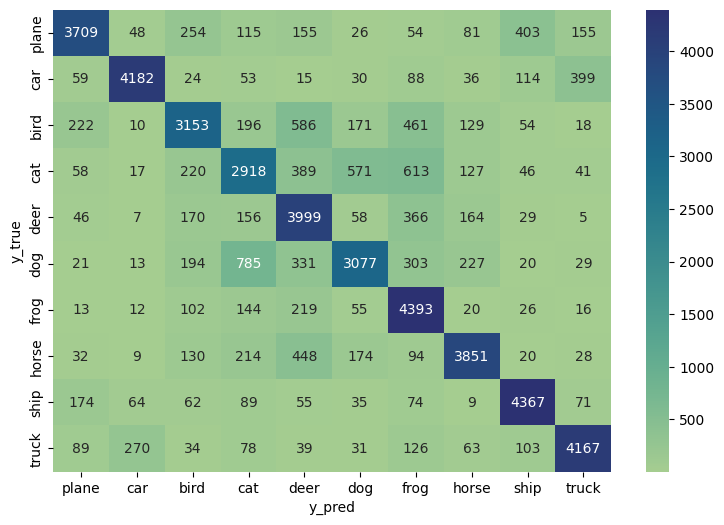

In [10]:
plot_confusion_matrix(model,atrain_loader,device,cifar.classes)